# Spatial domain identification on 10x Visium DLFPC data

In [1]:
import os
import torch
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from step import stModel
from step.utils.misc import set_seed
from sklearn.metrics import adjusted_rand_score
import anndata as ad

sc.settings.figdir = './results/DLPFC'
sc.set_figure_params(dpi_save=300, figsize=(6, 4.5))

/projects/82505004-e7a0-445f-ab3c-80d03c91438f/.cache/pypoetry/virtualenvs/step-Ajq_Bw_i-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir(os.path.expanduser('~/case-studies'))

## 151673 single section without using variational

In [3]:
set_seed(42)

In [4]:
stepc = stModel(
    file_path='./data/151673/151673_annotated.h5ad',
    n_top_genes=2000,
    layer_key=None,
    module_dim=30,
    hidden_dim=64,
    n_modules=10,
    decoder_type='zinb',
    variational=False,
    n_glayers=6
)

Trying seurat_v3 for hvgs
not log_transformed
Adding count data to layer 'counts'
Dataset Done
================Dataset Info================
Batch key: None 
Class key: None 
Number of Batches: 1 
Number of Classes: None 
Gene Expr: (3639, 2000)
Not using VAE


In [5]:
stepc.run(n_iterations=3000)

Training with e2e pattern
Training graph with single batch
100%|██████████| 3000/3000 [01:19<00:00, 37.96step/s, recon_loss=1622.729, contrast_loss=0.130, graph_ids=None]


In [6]:
adata = stepc.adata
adata

AnnData object with n_obs × n_vars = 3639 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'gd', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'MT_gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'MT', 'X_smoothed'
    layers: 'counts'

In [7]:
stepc.cluster(adata, use_rep='X_smoothed', n_clusters=7, key_added='cluster_',)

In [8]:
sc.pp.neighbors(adata, use_rep="X_smoothed", n_neighbors=100)
sc.tl.umap(adata)

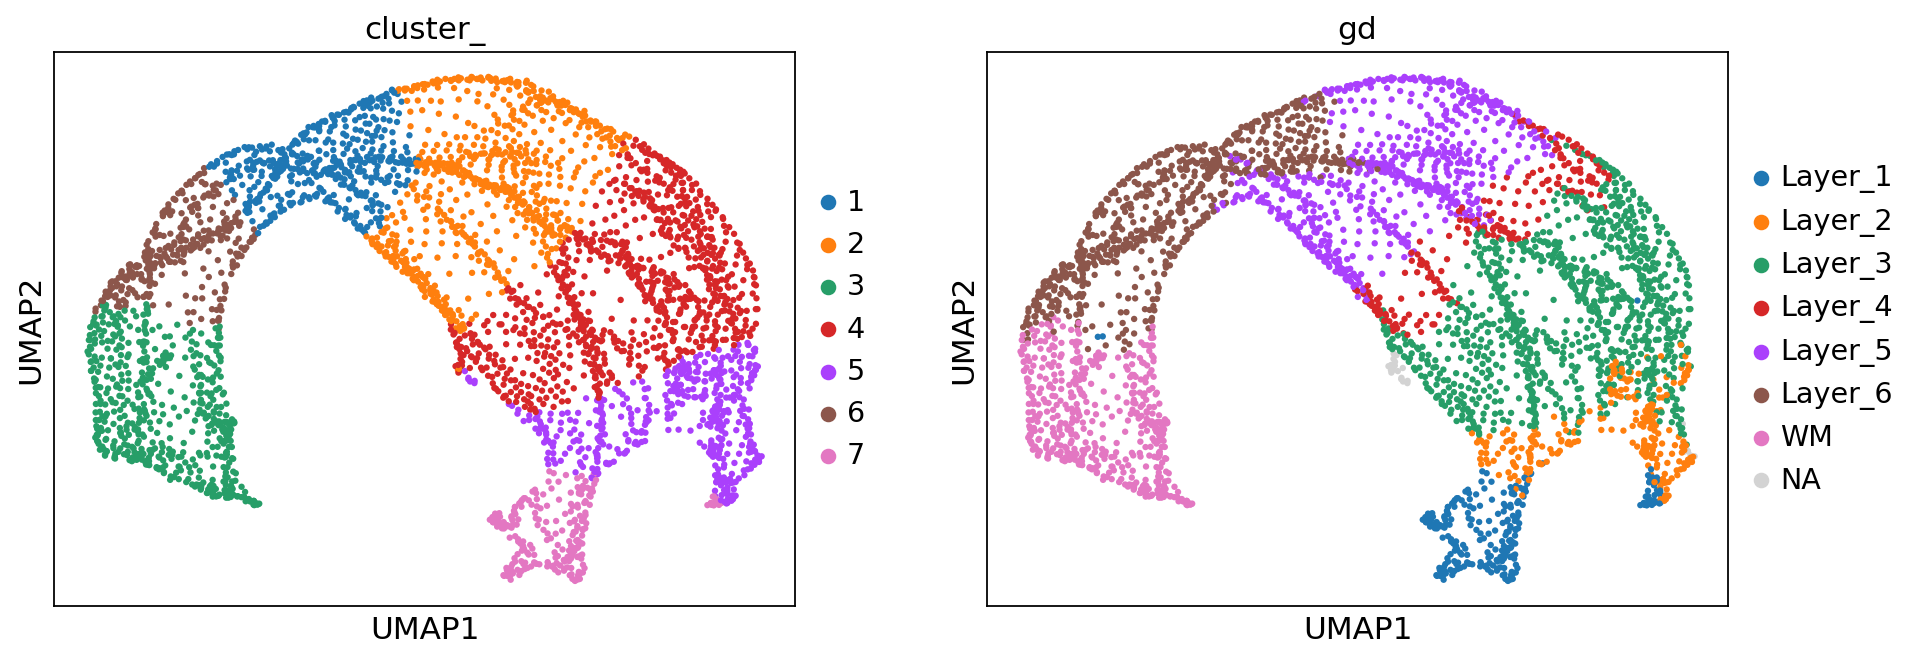

In [9]:
sc.pl.umap(adata, color=['cluster_', 'gd'])

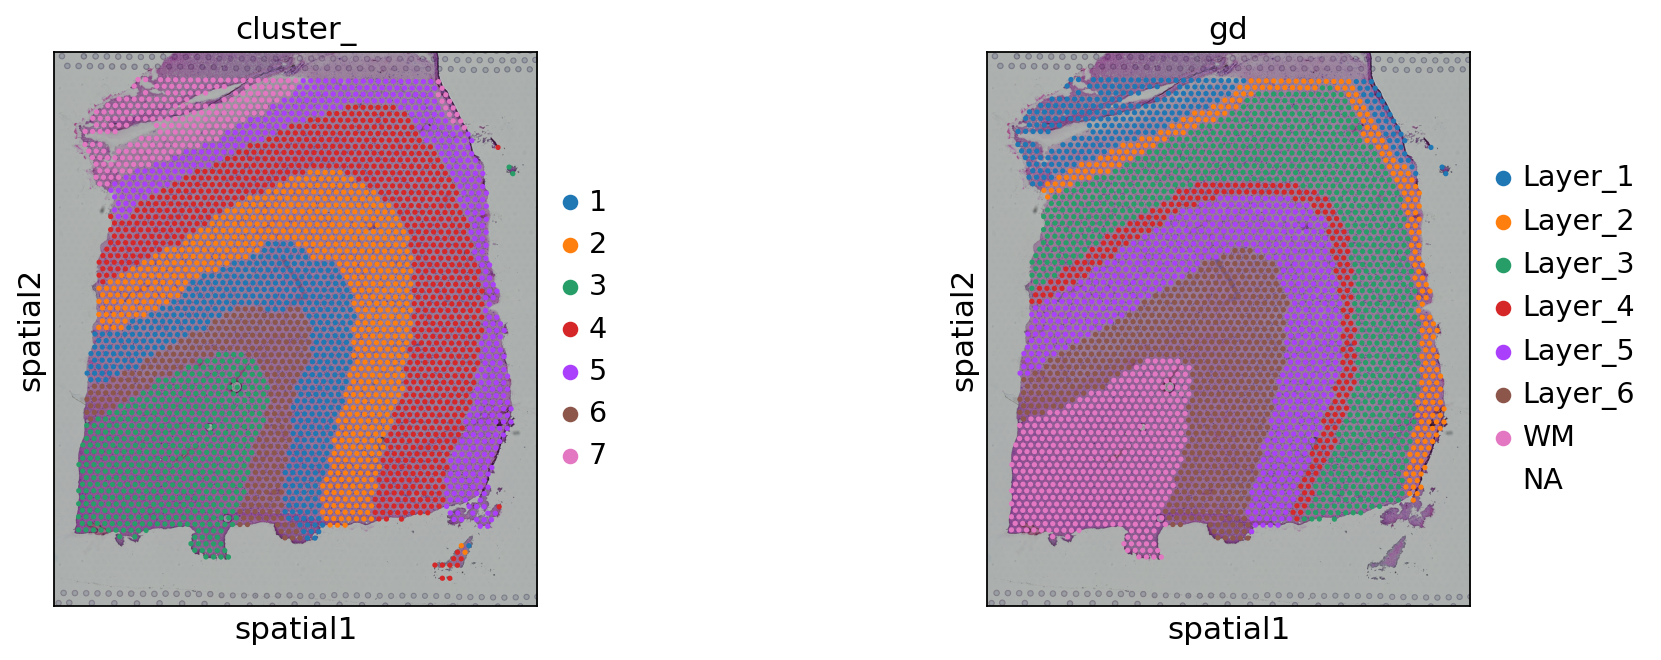

In [10]:
sc.pl.spatial(adata, color=['cluster_', 'gd'])

In [11]:
adata = adata[adata.obs['gd'].cat.codes != -1]
adjusted_rand_score(adata.obs['cluster_'], adata.obs['gd'].cat.codes)

0.6415591888519586

## 151673 single section with using variational

In [3]:
set_seed(123456)
stepc = stModel(
    file_path='./data/151673/151673_annotated.h5ad',
    n_top_genes=3000,
    layer_key=None,
    module_dim=30,
    hidden_dim=64,
    n_modules=16,
    decoder_type='zinb',
    n_glayers=3,
)

Trying seurat_v3 for hvgs
not log_transformed
Adding count data to layer 'counts'
Dataset Done
================Dataset Info================
Batch key: None 
Class key: None 
Number of Batches: 1 
Number of Classes: None 
Gene Expr: (3639, 3000)


In [4]:
stepc.run(n_samples=2400,
          n_iterations=3400,)

Training with e2e pattern
Training graph with single batch
100%|██████████| 3400/3400 [03:01<00:00, 18.71step/s, recon_loss=2270.652, kl_loss=0.142, contrast_loss=0.006, graph_ids=None]


In [5]:
adata = stepc.adata

stepc.cluster(adata, use_rep='X_smoothed', n_clusters=7, key_added='cluster_')
adata = adata[adata.obs['gd'].cat.codes != -1]

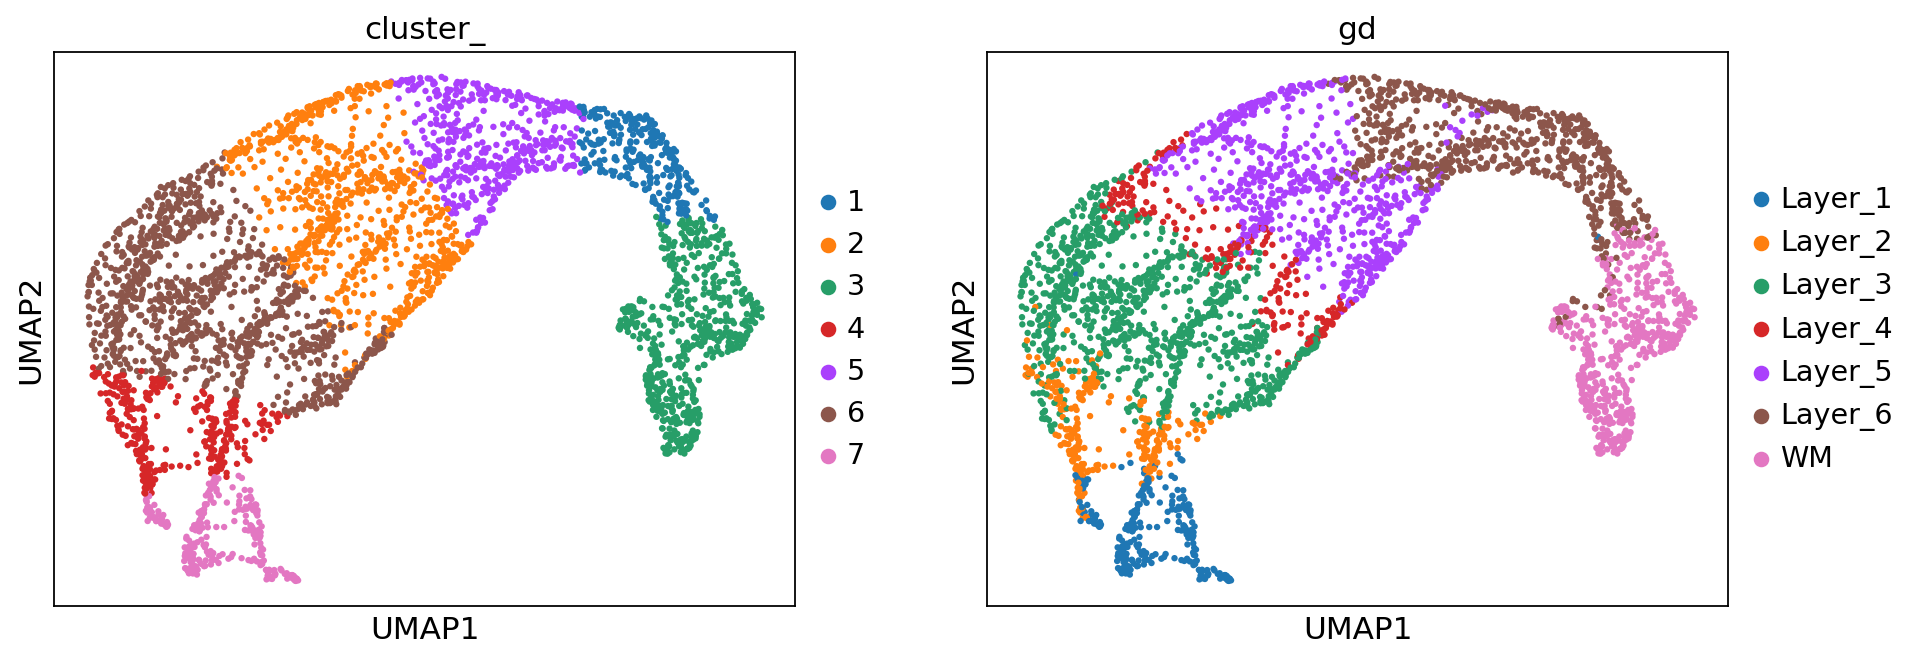

In [6]:
sc.pp.neighbors(adata, use_rep='X_smoothed', n_neighbors=100)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cluster_', 'gd'])

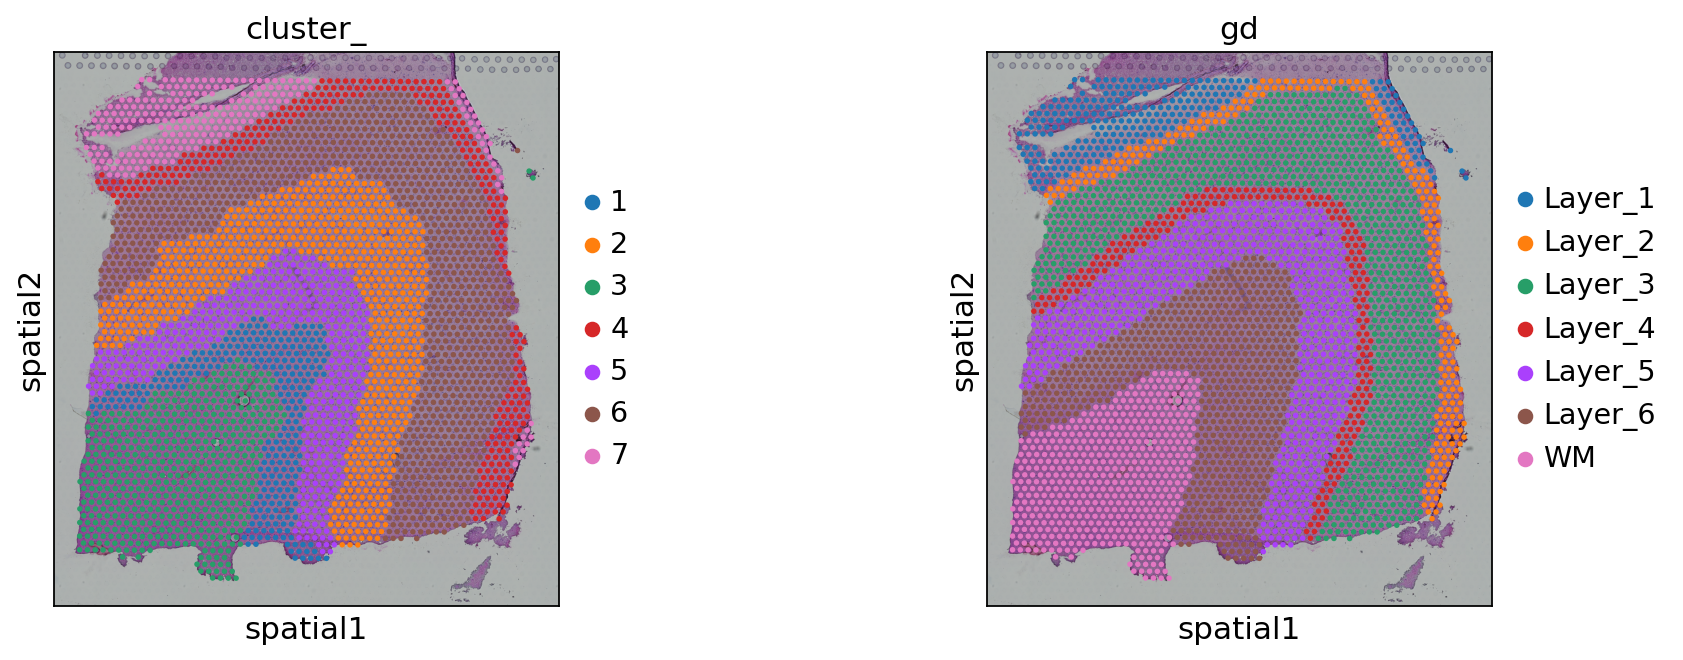

In [7]:
sc.pl.spatial(adata, color=['cluster_', 'gd'])

In [8]:
ari = adjusted_rand_score(adata.obs['cluster_'], adata.obs['gd'].cat.codes)
ari

0.6854871224605329

In [9]:
stepc.save("./results/DLPFC/151673-config/")

Saving model...
Saving model config...
Saving dataset config...


## 151673 to 151676 together

In [3]:
paths = [f'./data/{i}/{i}_annotated.h5ad' for i in range(151673, 151677)]
import os

adatas = [sc.read_h5ad(path) for path in paths]
adatas = {f'{151673 + i}': adata for i, adata in enumerate(adatas)}
adata = ad.concat(adatas, uns_merge='unique', label='batch')

In [4]:
adata.uns['spatial'].keys()

dict_keys(['151673', '151674', '151675', '151676'])

In [5]:
adata.obs['batch'].value_counts()

batch
151674    3673
151673    3639
151675    3592
151676    3460
Name: count, dtype: int64

In [6]:
stepc = stModel(
    adata=adata,
    n_top_genes=2000,
    batch_key='batch',
    n_modules=10,
    decoder_type='zinb',
    variational=True,
    dec_norm='batch',
    n_glayers=6,
    dispersion="gene"
)

Trying seurat_v3 for hvgs
not log_transformed
Adding count data to layer 'counts'
Dataset Done
================Dataset Info================
Batch key: batch 
Class key: None 
Number of Batches: 4 
Number of Classes: None 
Gene Expr: (14364, 2000)
Batch Label: (14364,)


<div class="alert alert-info">

**Note:** The results in paper were obtained by setting `beta=1e-3`
</div>

In [7]:
stepc.run(graph_batch_size=2, 
           n_iterations=2000,
           beta=1e-5,)

Training with e2e pattern
Training graph with multiple batches
Constructing graph for batch 151673
Constructing graph for batch 151674
Constructing graph for batch 151675
Constructing graph for batch 151676
100%|██████████| 2000/2000 [04:05<00:00,  8.14step/s, recon_loss=1045.916, kl_loss=0.002, contrast_loss=0.579, graph_ids=[0, 1]]


In [8]:
stepc.cluster(n_clusters=7, key_added='cluster_',)
adata = stepc.adata
aris = []
for i in range(151673, 151677):
    _adata = adata[adata.obs['batch'] == str(i)]
    ari = adjusted_rand_score(_adata.obs['cluster_'], _adata.obs['gd'].cat.codes)
    aris.append(ari)
print(aris)
    
adata = stepc.adata

[0.6859044700752418, 0.6737134878196837, 0.6574160363368401, 0.645033638093529]


In [9]:
sc.pp.neighbors(adata, use_rep="X_smoothed", n_neighbors=60)
sc.tl.umap(adata)

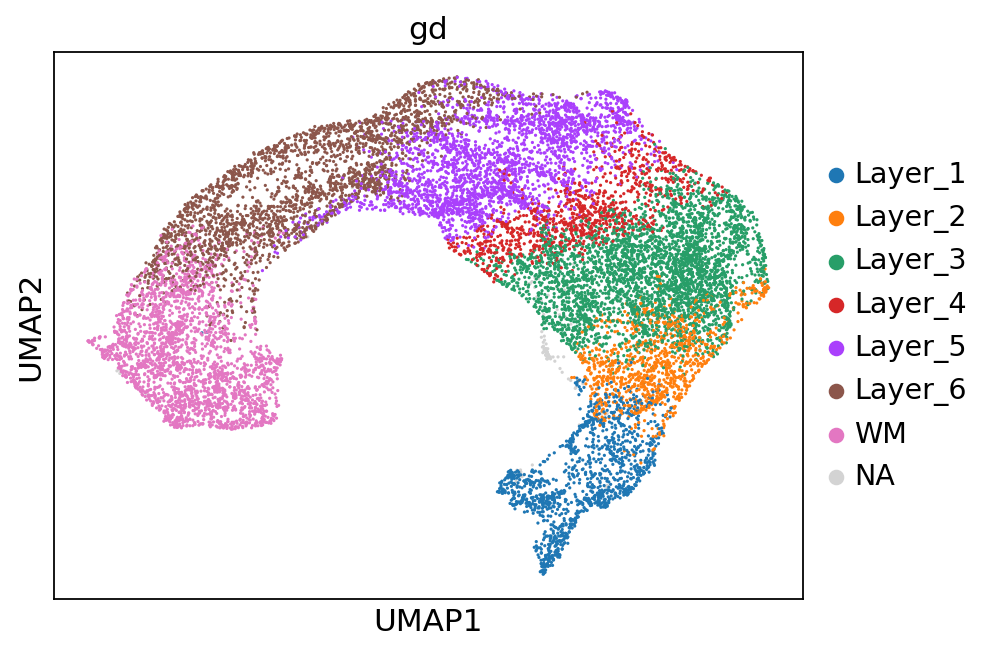

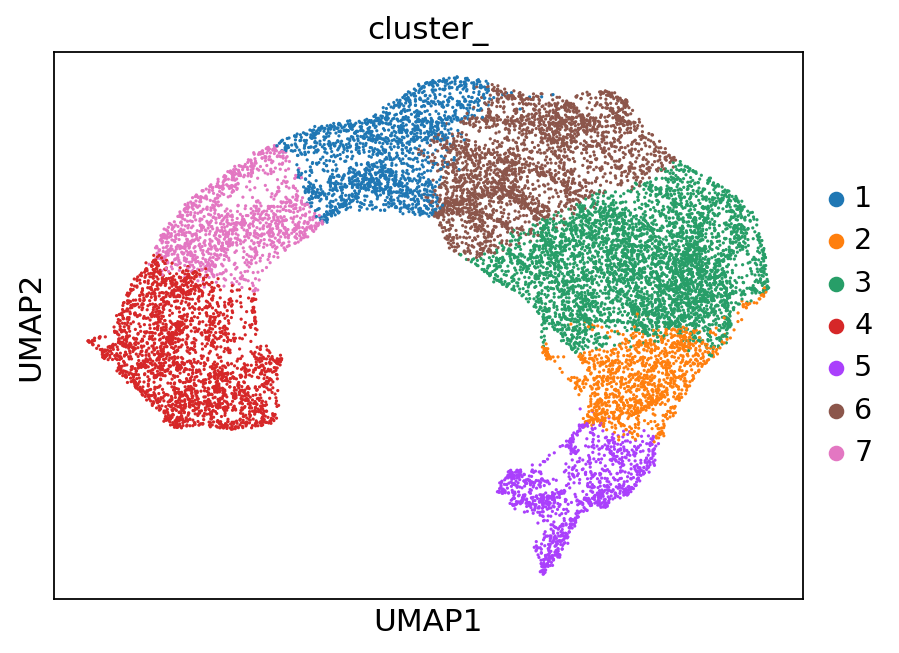

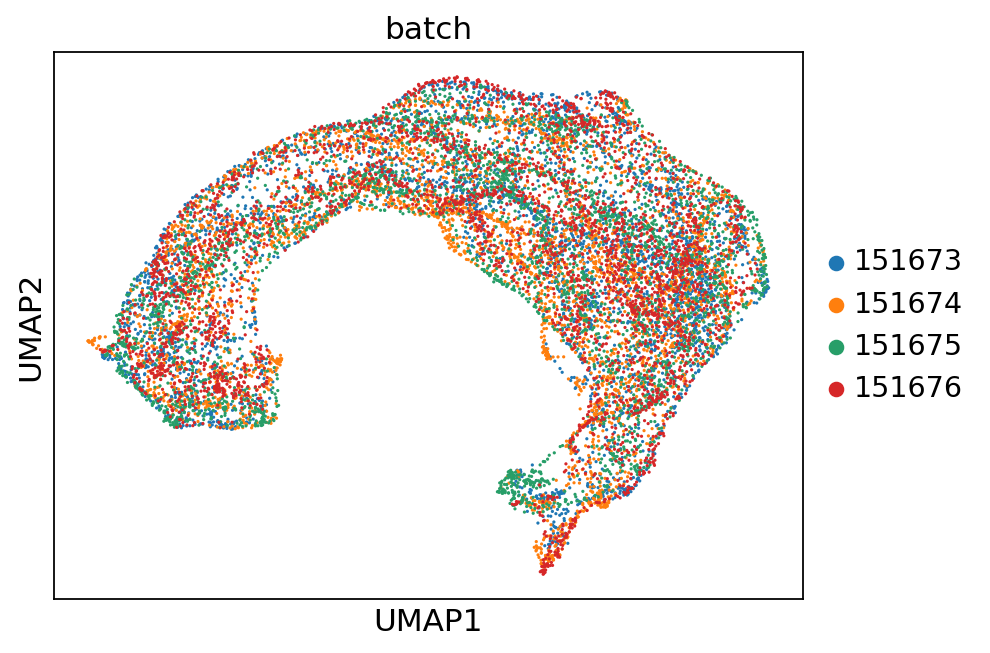

In [10]:
for col in ['gd', 'cluster_', 'batch']:
    sc.pl.umap(adata, color=col)

### Spatial plots and ARIs without NA spots

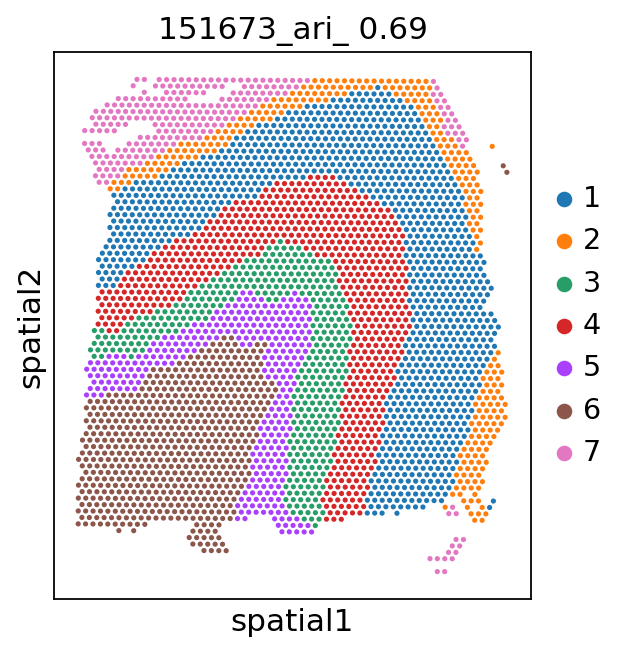

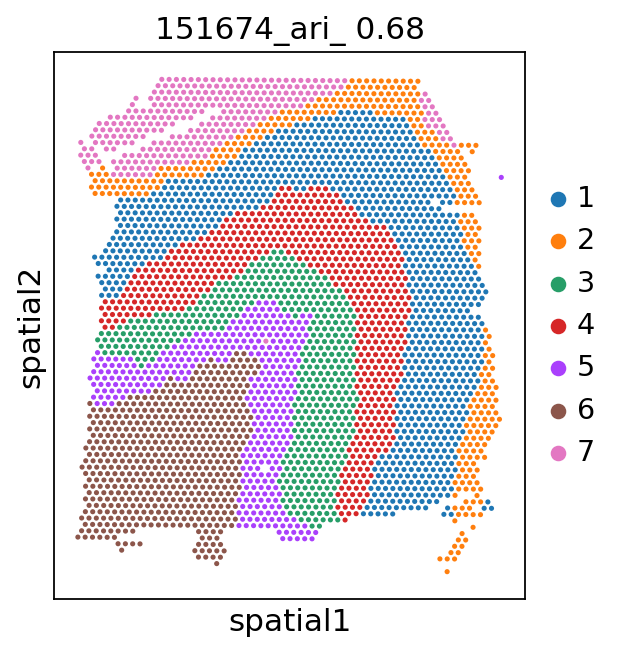

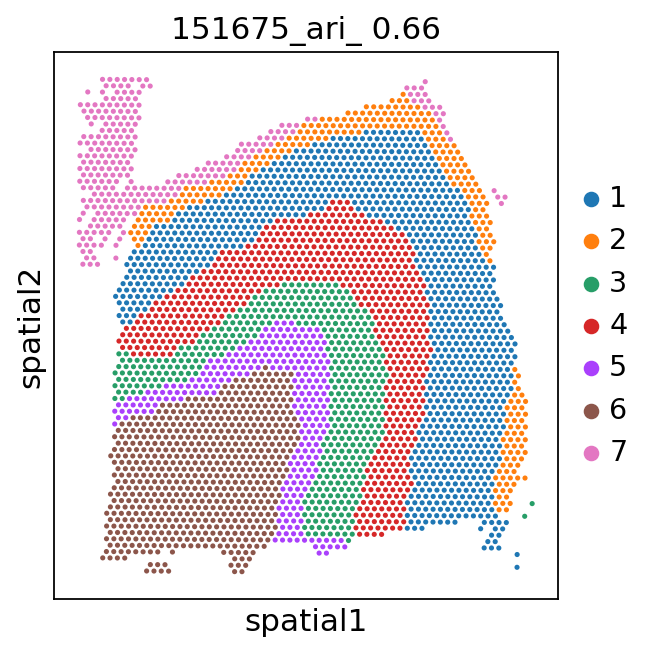

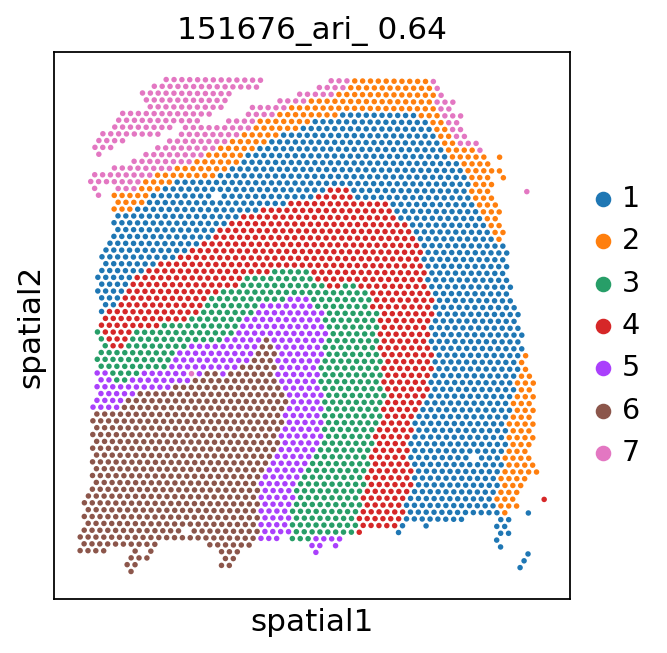

In [9]:
for i in range(151673, 151677):
    _adata = adata[adata.obs['batch'] == str(i)]
    ari_kmeans = adjusted_rand_score(_adata.obs['cluster_'], _adata.obs['gd'].cat.codes)
    sc.pl.spatial(_adata, color='cluster_', library_id=str(i), 
                  img_key=None,
                  title=f'{i}_ari_{ari_kmeans: .2f}',
                 )

In [11]:
stepc.save("./reuslts/dlfpc-p3-together")

Saving model...
Saving model config...
Saving dataset config...


In [10]:
from sklearn.metrics import adjusted_rand_score

adata = adata[adata.obs['gd'].cat.codes != -1]
for i in range(151673, 151677):
    _adata = adata[adata.obs['batch'] == str(i)]
    ari_kmeans = adjusted_rand_score(_adata.obs['cluster_'], _adata.obs['gd'].cat.codes)
    print(f"{i}: {ari_kmeans}")

151673: 0.693643745029269
151674: 0.6823133597364682
151675: 0.6644988100827957
151676: 0.6493974579858672
